<a href="https://colab.research.google.com/github/ishandahal/stats453-deep_learning_torch/blob/main/Logistic_/Softmax_regression_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Softmax Regression on MNIST

In [1]:
import time
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch

Settings and Dataseta

In [2]:
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

# hyperparameters
random_seed = 123
learning_rate = 0.1
num_epochs = 25
batch_size = 256

# architecture
num_features = 784
num_classes = 10

## MNIST Dataset

train_dataset = datasets.MNIST(root='data',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data',
                              train=False,
                              transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

# checking the dataset
for images, label in train_loader:
    print("Image batch dimension: ", images.shape)
    print("Image label dimensions: ", label.shape)
    break

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)




Image batch dimension:  torch.Size([256, 1, 28, 28])
Image label dimensions:  torch.Size([256])


In [3]:
## Model 

class SoftmaxRegression(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(SoftmaxRegression, self).__init__()
        self.linear = torch.nn.Linear(num_features, num_classes)

        self.linear.weight.detach().zero_()
        self.linear.bias.detach().zero_()

    def forward(self, x):
        logits = self.linear(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

model = SoftmaxRegression(num_features=num_features,
                          num_classes=num_classes)
model.to(device)

## optimizer

optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [4]:
# Manual seed for deterministic data loader
torch.manual_seed(random_seed)

def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0

    for features, targets in data_loader:
        features = features.view(-1, 28*28).to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    
    return correct_pred.float() / num_examples * 100

start_time = time.time()
epoch_costs = []
for epoch in range(num_epochs):
    avg_cost = 0.
    for batch_idx, (features, targets) in enumerate(train_loader):

        features = features.view(-1, 28*28).to(device)
        targets = targets.to(device)

        # forward and back prop
        logits, probas = model(features)

        # PyTorch implementation of 
        # cross_entropy works with logits
        # not probabilities
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        cost.backward()
        avg_cost += cost
        avg_cost

        # update model parameters
        optimizer.step()

        # logging 
        if not batch_idx % 50:
            print(f'Epoch: {epoch + 1:03d}/{num_epochs:03d} | Batch {batch_idx:03d}'
                    f'/{len(train_dataset) // batch_size} | Cost: {cost:.4f}')

    with torch.set_grad_enabled(False):
        avg_cost = avg_cost / len(train_dataset)
        epoch_costs.append(avg_cost)
        print(f"Epoch: {epoch+1:03d}/{num_epochs} training accuracy: {compute_accuracy(model, train_loader):.2f}%")
        print(f'Time Elapsed: {(time.time() - start_time) / 60:.2f}min')

Epoch: 001/025 | Batch 000/234 | Cost: 2.3026
Epoch: 001/025 | Batch 050/234 | Cost: 0.7819
Epoch: 001/025 | Batch 100/234 | Cost: 0.6426
Epoch: 001/025 | Batch 150/234 | Cost: 0.5026
Epoch: 001/025 | Batch 200/234 | Cost: 0.4742
Epoch: 001/25 training accuracy: 88.06%
Time Elapsed: 0.19min
Epoch: 002/025 | Batch 000/234 | Cost: 0.4454
Epoch: 002/025 | Batch 050/234 | Cost: 0.4151
Epoch: 002/025 | Batch 100/234 | Cost: 0.4108
Epoch: 002/025 | Batch 150/234 | Cost: 0.3915
Epoch: 002/025 | Batch 200/234 | Cost: 0.3253
Epoch: 002/25 training accuracy: 89.39%
Time Elapsed: 0.38min
Epoch: 003/025 | Batch 000/234 | Cost: 0.3777
Epoch: 003/025 | Batch 050/234 | Cost: 0.3984
Epoch: 003/025 | Batch 100/234 | Cost: 0.3044
Epoch: 003/025 | Batch 150/234 | Cost: 0.3907
Epoch: 003/025 | Batch 200/234 | Cost: 0.4255
Epoch: 003/25 training accuracy: 89.85%
Time Elapsed: 0.56min
Epoch: 004/025 | Batch 000/234 | Cost: 0.3918
Epoch: 004/025 | Batch 050/234 | Cost: 0.3700
Epoch: 004/025 | Batch 100/234 |

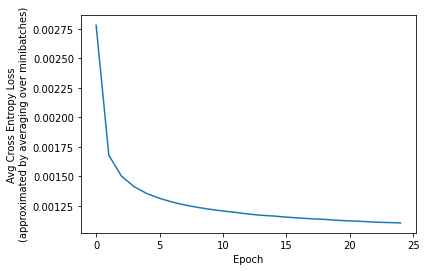

In [5]:
import matplotlib
import matplotlib.pyplot as plt


plt.plot(epoch_costs)
plt.ylabel('Avg Cross Entropy Loss\n(approximated by averaging over minibatches)')
plt.xlabel('Epoch')
plt.show()

In [6]:
print('Testing accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Testing accuracy: 92.16%


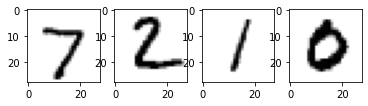

In [7]:
for features, targets in test_loader:
    break

fig, ax = plt.subplots(1, 4)
for i in range(4):
    ax[i].imshow(features[i].view(28, 28), cmap=matplotlib.cm.binary)

plt.show()

In [9]:
_, predictions = model(features[:4].view(-1, 28*28).to(device))
predictions = torch.argmax(predictions, dim=1)
print(f"Predicted labels:", predictions)

Predicted labels: tensor([7, 2, 1, 0])
